In [1]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Input,Dense,Conv2D,BatchNormalization,Dropout,Flatten
#Conv2DTranspose is used to go in a reverse order in neural network,reverse of feed forward
from keras.layers import Activation,Reshape,Conv2DTranspose,UpSampling2D
from keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
input_images = 'db/apple.npy'
data=np.load(input_images)

In [3]:
data.shape

(144722, 784)

In [4]:
data[4242]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  36,  79,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 134, 238,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 119, 254,   4,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 101, 255,  21,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  82, 255,  39,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [5]:
data=data/255
data=np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h=data.shape[1:3]
data.shape

(144722, 28, 28, 1)

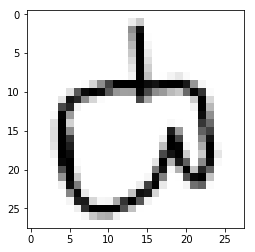

In [6]:
plt.imshow(data[4242,:,:,0],cmap='Greys')

In [7]:
# Here we a creating a convolutional network and we are increasing the depth as we go to next layer
# We are feeding the result from previous layer to new set of layers so that we can convolve on previous results.
def discriminator_builder(depth=64,p=0.4):
    inputs=Input((img_w,img_h,1))
    
    #Conv2D has 64 neurons because depth is defined above as 64
    #We are feeding back the first layer to same layer with a Droupout so that irrelevent pixels are droupped out.
    #Map size is 5X5 and strides the postion after which next map should be located is 2
    Conv1=Conv2D(depth*1,5,strides=2,padding='same',activation='relu')(inputs)
    Conv1=Dropout(p) (Conv1)
    
    #Here we are trying to deepen the network by increasing the neurons.
    Conv2=Conv2D(depth*2,5,strides=2,padding='same',activation='relu')(Conv1)
    Conv2=Dropout(p) (Conv2)
    
    Conv3=Conv2D(depth*4,5,strides=2,padding='same',activation='relu')(Conv2)
    Conv3=Dropout(p) (Conv3)
    
    #Here as we are increasing neurons we have reduced the position after next map should be taken
    #This helps to moniter the image more closely.
    #So after removal of waste areas from map now we can moniter the image more closely so it will focus on needed areas more effectively 
    Conv4=Conv2D(depth*8,5,strides=1,padding='same',activation='relu')(Conv3)
    Conv4=Flatten() (Dropout(p)(Conv4))
    
    #Conv5=Conv2D(depth*16,5,strides=1,padding='same',activation='relu')(Conv4)
    #Conv5=Dropout(p) (Conv5)
    
    output=Dense(1,activation='sigmoid')(Conv4)
    model=Model(inputs = inputs,outputs=output)
    model.summary()
    return model

In [8]:
discriminator=discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [9]:
discriminator.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.0008,decay=6e-8,clipvalue=1.0),metrics=['accuracy'])

In [19]:
#This is generator network which is de convolutional.
#The latent space is 100 dimensions
def generator_builder(z_dim=100,depth=64,p=0.4):
    #Define Inputs
    inputs=Input((z_dim,))
    
    #First Dense Layer
    #We are starting with 7 by 7 pixel size
    dense1=Dense(7*7*64)(inputs)
    dense1=BatchNormalization(momentum=0.9)(dense1) #default momentum for moving average is 0.99
    dense1=Activation(activation='relu')(dense1)
    dense1=Reshape((7,7,64))(dense1)
    dense1=Dropout(p)(dense1)
    
    #De-Convolutional layers
    conv1=UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2),kernel_size=5,padding='same',activation=None,)(conv1)
    conv1=BatchNormalization(momentum=0.9)(conv1)
    conv1=Activation(activation='relu')(conv1)
    
    conv2=UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4),kernel_size=5,padding='same',activation=None,)(conv2)
    conv2=BatchNormalization(momentum=0.9)(conv2)
    conv2=Activation(activation='relu')(conv2)
    
    #conv3=UpSampling2D()(c#onv2)
    conv3 = Conv2DTranspose(int(depth/8),kernel_size=5,padding='same',activation=None,)(conv2)
    conv3=BatchNormalization(momentum=0.9)(conv3)
    conv3=Activation(activation='relu')(conv3)
    
    #conv4=UpSampling2D()(conv3)
    #conv4 = Conv2DTranspose(int(depth/16),kernel_size=5,padding='same',activation=None,)(conv4)
    #conv4=BatchNormalization(momentum=0.9)(conv4)
    #conv4=Activation(activation='relu')(conv4)
    
    #Output Layer
    output=Conv2D(1,kernel_size=5,padding='same',activation='sigmoid')(conv3)
    
    #Model defination
    model=Model(inputs=inputs,outputs=output)
    model.summary()
    
    return model

In [20]:
generator=generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_5 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_5 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 64)        0         
__________

In [21]:
def adversarial_builder(z_dim=100):
    model=Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy',
                 optimizer=RMSprop(lr=0.0004,decay=3e-8,clipvalue=1.0),
                 metrics=['accuracy'])
    model.summary()
    return model

In [22]:
adversarial_model=adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 28, 28, 1)         396961    
_________________________________________________________________
model_1 (Model)              (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


In [23]:
def make_trainable(net,val):
    net.trainable=val
    for l in net.layers:
        l.trainable=val

In [24]:
np.random.uniform(-1.0,1.0,size=[128,100])

array([[ 0.13398943,  0.12099034,  0.59903298, ..., -0.40538352,
        -0.98415901, -0.46295837],
       [-0.92597916, -0.2190355 ,  0.87063231, ..., -0.92888723,
        -0.25556676,  0.53981755],
       [-0.4057874 ,  0.80841683,  0.37234066, ...,  0.97337493,
        -0.5036212 ,  0.71595759],
       ...,
       [-0.46916791,  0.89431514, -0.84168464, ..., -0.10509197,
        -0.71100974,  0.33063381],
       [-0.80176373, -0.9994693 , -0.57998598, ...,  0.58571893,
        -0.12141564,  0.40801955],
       [-0.92787792, -0.46360331,  0.42560615, ..., -0.15867306,
        -0.6234308 , -0.90290414]])

In [25]:
data[np.random.choice(data.shape[0],128,replace=False)].shape

(128, 28, 28, 1)

In [26]:
np.reshape(data[np.random.choice(data.shape[0],128,replace=False)],(128,28,28,1)).shape

(128, 28, 28, 1)

In [27]:
#generator.predict(np.random.uniform(-1.0,1.0,size=[128,100])).shape
real_imgs=np.reshape(data[np.random.choice(data.shape[0],128,replace=False)],(128,28,28,1))
fake_imgs=generator.predict(np.random.uniform(-1.0,1.0,size=[128,100]))

x=np.concatenate((real_imgs,fake_imgs))
y=np.ones([2*128,28,28,1])
y[128:,:]=0
#x.shape
y.shape

(256, 28, 28, 1)

In [35]:
def train(epochs=2000,batch=128):
    d_metrics=[]
    a_metrics=[]
    
    running_d_loss=0
    running_d_acc=0
    running_a_loss=0
    running_a_acc=0
    
    for i in range(epochs):
        print(i)
        if(i%100==0):
            print(i)
            
        real_imgs=np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs=generator.predict(np.random.uniform(-1.0,1.0,size=[batch,100]))
        
        x=np.concatenate((real_imgs,fake_imgs))
        y=np.ones([2*batch,1])
        #y=np.ones([2*batch,4,4,1])
        y[batch:,:]=0
        
        make_trainable(discriminator,True)
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator,False)
        
        noise=np.random.uniform(-1.0,1.0,size=[batch,100])
        y=np.ones([batch,1])
        #y=np.ones([batch,4,4,1])
        
        make_trainable(adversarial_model,True)
        a_metrics.append(adversarial_model.train_on_batch(noise,y))
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        make_trainable(adversarial_model,False)
        
        if(i+1)%500 == 0:
            print('Epoch #{}'.format(i+1))
            log_mesg="%d: [D loss:%f,acc:%f]" % (i,running_d_loss/i,running_d_acc/i)
            log_mesg="%s  [A loss:%f,acc:%f]" % (log_mesg,running_a_loss/i,running_a_acc/i)
            print(log_mesg)
            
        noise=np.random.uniform(-1.0,1.0,size=[16,100])
        gen_imgs=generator.predict(noise)
            
        plt.figure(figsize=(5,5))
            
        for k in range(gen_imgs.shape[0]):
            plt.subplot(4,4,k+1)
            plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()
    return a_metrics,d_metrics

0
0


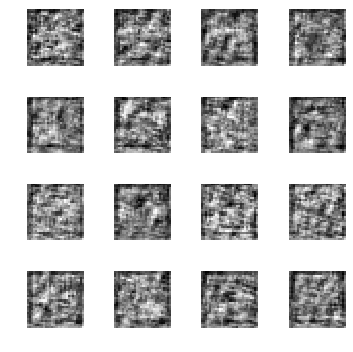

1


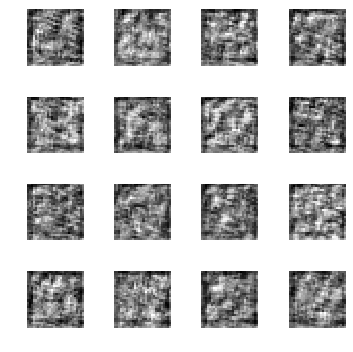

2


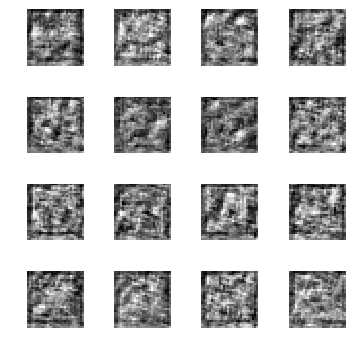

3


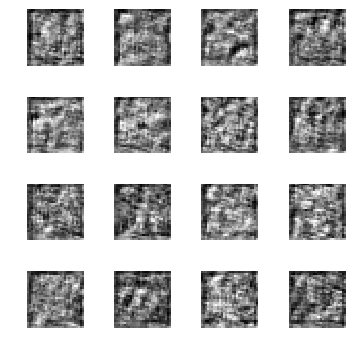

4


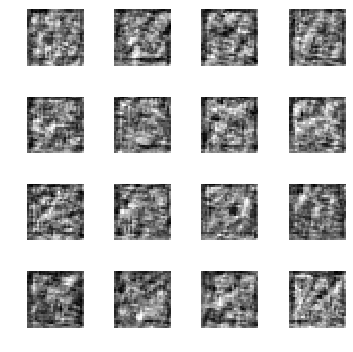

5


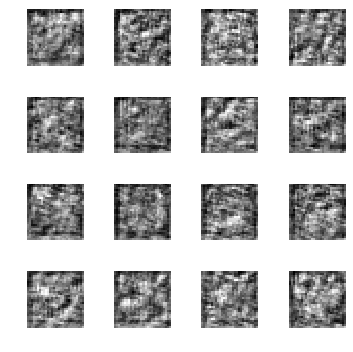

6


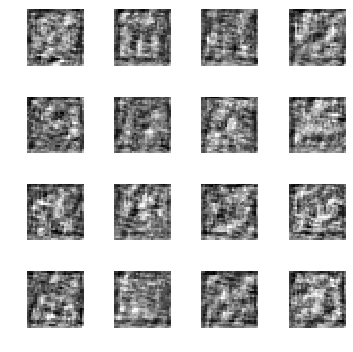

7


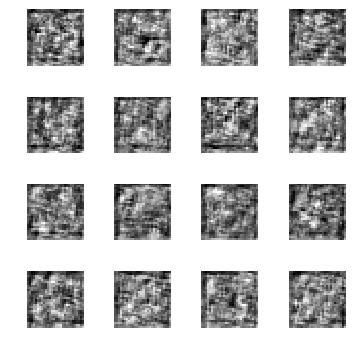

8


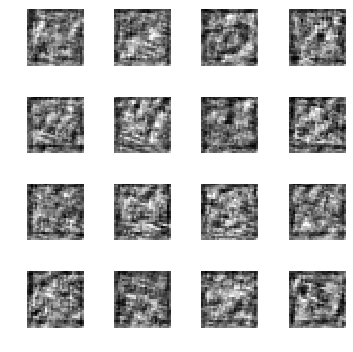

9


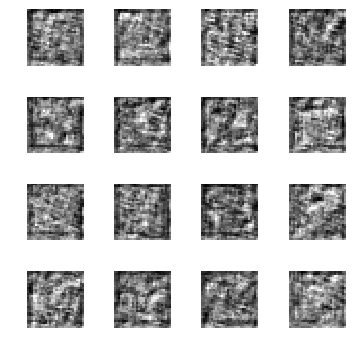

10


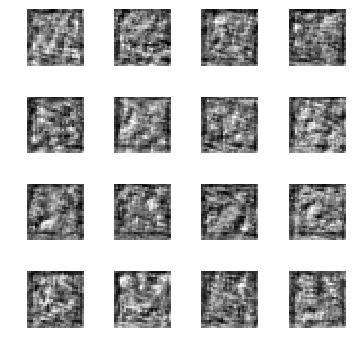

11


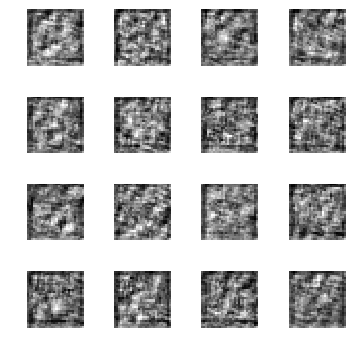

12


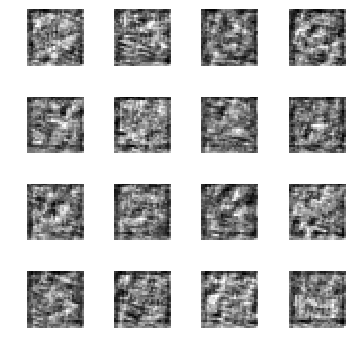

13


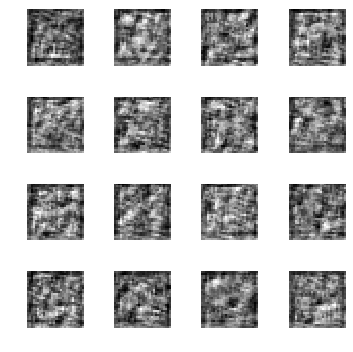

14


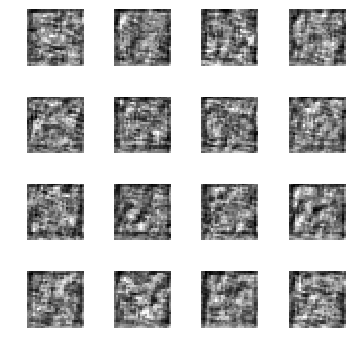

In [40]:
a_metrics_complete,d_metrics_complete=train(epochs=15)

Text(0, 0.5, 'Loss')

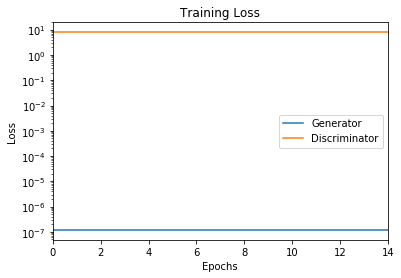

In [41]:
ax=pd.DataFrame(
    {
        'Generator':[metric[0] for metric in a_metrics_complete],
        'Discriminator':[metric[0] for metric in d_metrics_complete]
    }
).plot(title='Training Loss',logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

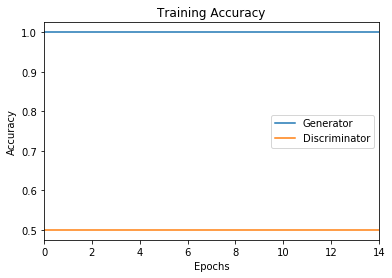

In [42]:
ax=pd.DataFrame(
    {
        'Generator':[metric[1] for metric in a_metrics_complete],
        'Discriminator':[metric[1] for metric in d_metrics_complete]
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")